Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 2  
Due: May 2, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
wd = "/mnt/Backups/jmhu"

data_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/data/"
model_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/models/"
fig_dir = wd + "/git_dirs/ComplexSystems_AMATH563/hw2/figures/"
    
if not os.path.exists(data_dir):
    !mkdir $data_dir

if not os.path.exists(model_dir):
    !mkdir $model_dir

if not os.path.exists(fig_dir):
    !mkdir $fig_dir

### Load data

In [4]:
df = pd.read_csv(data_dir+"population_data.csv")
df.head()

,Year,Hare,Lynx
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


### Question 1. Develop a DMD model to forecast the future population states

In [5]:
# Functions
def densify(t,y,dt):
    '''From Friedrich'''
    from scipy.interpolate import interp1d
    f = interp1d(t, y, kind='cubic')
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    return(tnew, ynew)

def DMD(X,Xprime,r, dt=2):
    '''Dynamic Mode Decomposition Function from book'''
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    Omega = np.log(np.diag(Lambda))/dt
    return Phi, Omega, b, Lambda

#### Set-up matrices

In [6]:
X=df.values[:, 1:3]
# X=df.values[:-1, 1:3]
# Xprime=df.values[1:, 1:3]

In [7]:
# Heavily interpolate
t = df.Year.values
dt = (t[1] - t[0])/100 # make 10 times more points ()

# Interpolate for more points
years, dense_hare = densify(t, df.Hare.values, dt)
years, dense_lynx = densify(t, df.Lynx.values, dt)

X_dense=np.stack((dense_hare, dense_lynx)).T # in form time, states

# DMD set-up
X=X_dense[:-1,:]
Xprime=X_dense[1:,:]

# Transpose matrices
# two state variables, want observations on other dimension
X=X.T
Xprime=Xprime.T
print(X.shape, Xprime.shape)

(2, 2899) (2, 2899)


#### Run DMD

In [8]:
r=2

Phi_X, Omega_X, b_X, Lambda_X = DMD(X, Xprime, r)
print(" Phi : Omega : b ", )
print(Phi_X.shape, Omega_X.shape, b_X.shape)

 Phi : Omega : b 
(2, 2) (2,) (2,)


In [9]:
Lambda_X
# Lambda_Y

array([[0.99990455+0.00268497j, 0.        +0.j        ],
       [0.        +0.j        , 0.99990455-0.00268497j]])

# Finally, imaginary numbers!

In [10]:
b_X

array([-16.34450657-42.00711389j, -16.34450657+42.00711389j])

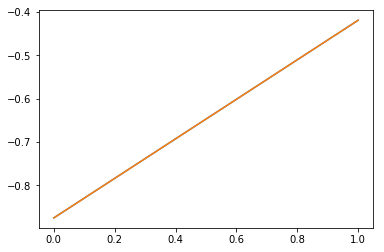

In [27]:
plt.plot(np.real(Phi_X))

## DMD reconstruction as in dmd_intro.m

In [37]:
t=X.shape[1]
u_modes = np.zeros((2, t))

dt=2
time_vector = dt*np.arange(-1, t-1)

for i in np.arange(0, t):
    u_modes[:, i]=b_X*np.exp(Omega_X*time_vector[i])

Xdmd=Phi_X@u_modes
print(t, u_modes.shape, time_vector.shape, Xdmd.shape)

2899 (2, 2899) (2899,) (2, 2899)


/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


## Plot DMD reconstruction

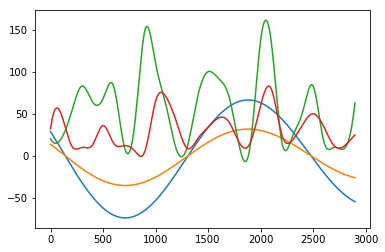

In [38]:
plt.plot(Xdmd.T)
plt.plot(X.T)

### => => => No imaginary components for Lambda values with only 29 points!

In [39]:
def forecast(Phi, Omega, t, b):
    f = Phi@np.exp(Omega*t)*b
    return(f)

def forecast_t(Phi, Lambda, t, b, IC):
    '''hares_t'''
    Omega = np.log(Lambda)/2
    f = np.array(Phi*np.exp(Omega*t)*b).squeeze()
#     f1 = np.array(Phi*np.exp(Omega*t)*b).squeeze()
#     f2 = np.array(Phi*np.exp(-Omega*t)*b).squeeze()
#     f = f1 + f2
    f = np.insert(arr=f, obj=0, values=IC)
    return(f)

def forecast_not(Phi, Lambda, b, IC):
    '''dmd_hares, now hares_not'''
    Omega = np.log(Lambda)/2
    f = np.array(Phi*np.exp(Omega)*b).squeeze()
    f = np.insert(arr=f, obj=0, values=IC)
    return(f)

In [30]:
# Attempt to make this like the Xdmd above, should work...
for i in np.arange(0, t):
    u_modes[:, i] = forecast(Phi_X, Omega_X, i, b_X)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


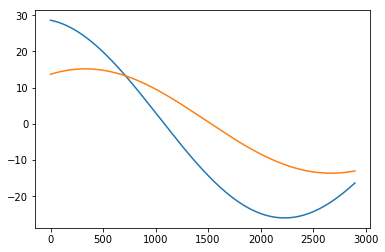

In [33]:
plt.plot(u_modes.T)

In [11]:
# Without time + IC
hares_not = forecast_not(Phi_X, Lambda_X, b_X, df.Hare.values[0])

#  With time + IC
hares_t = []
lynx_t = []

years=df.Year.values
for t in range(len(years)-1):
    hares_t.append(forecast_t(Phi_X, Lambda_X, t, b_X, df.Hare.values[0]))
    lynx_t.append(forecast_t(Phi_Y, Lambda_Y, t, b_Y, df.Lynx.values[0]))
    
# Convert to arrays and remove singleton dimensions
hares_t = np.array([(h) for h in hares_t]).squeeze()
lynx_t = np.array([(l) for l in lynx_t]).squeeze()

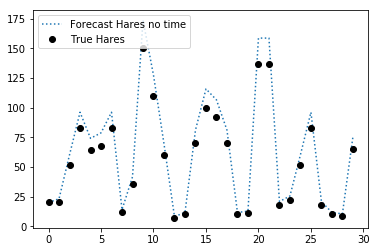

In [12]:
plt.figure()
# plt.plot(hares_t, "b--", label="Forecast Hares")
plt.plot(hares_not, ":", label="Forecast Hares no time")

plt.plot(df.Hare, "ko", label="True Hares")
plt.legend(loc="upper left")

### Question 2.  Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables.

In [16]:
X=df.Hare.values
Y=df.Lynx.values

from scipy.linalg import hankel

# Construct Hankel matrix
H_X = hankel(X)
H_Y = hankel(Y)

print(H_X.shape, H_Y.shape)

(30, 30) (30, 30)


21
20


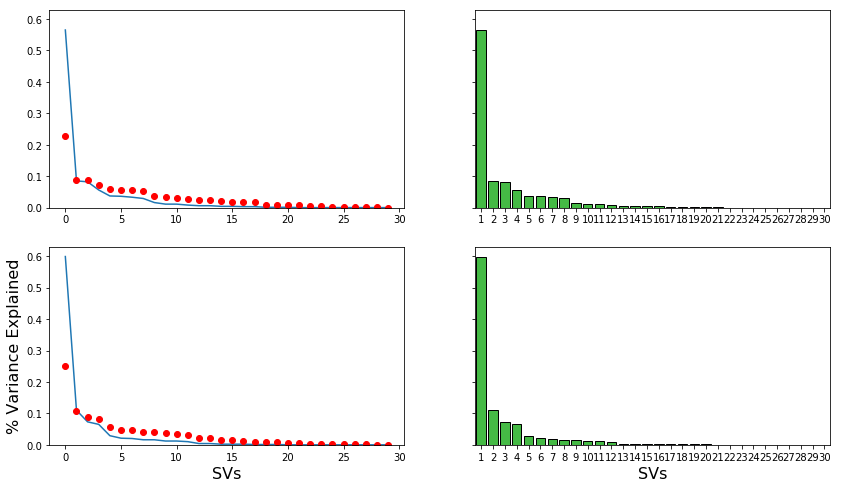

In [17]:
import seaborn as sns

# Take SVD of H_X
u, s, v = np.linalg.svd(H_X)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))

fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
ax[0,0].plot(var_explained)
ax[0,0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
ax[1,0].set_xlabel('SVs', fontsize=16)
ax[1,0].set_ylabel('% Variance Explained', fontsize=16)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[0,1])

# Take SVD of H_Y
u, s, v = np.linalg.svd(H_Y)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))
ax[1,0].plot(var_explained)
ax[1,0].plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");


sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax[1,1])
plt.xlabel('SVs', fontsize=16);

#### SVD of Hankel matrix shows that there are 20 and 21 non-zero modes for hare and lynx populations based on this small dataset

This suggests that there are quite a few latent variables not being measured in this dynamic system as we are only measuring 2 variables (lynx and hare)

Hankel shape: (60, 60)
39


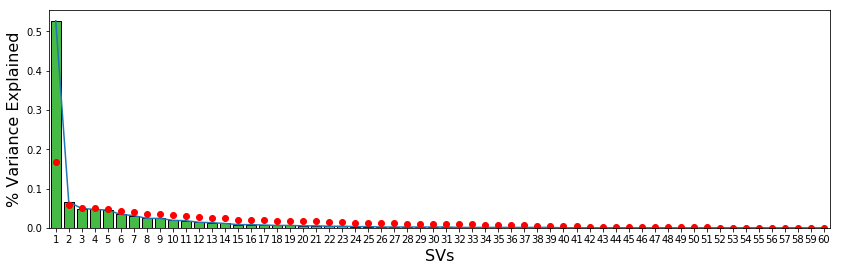

In [18]:
import seaborn as sns

# Construct Hankel matrix
combined=df.values[:, 1:]
H_combined = hankel(combined)
print("Hankel shape:", H_combined.shape)

# Take SVD of H
u, s, v = np.linalg.svd(H_combined)
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(len(var_explained[var_explained>0]))

fig, ax = plt.subplots(1, figsize=(14, 4), sharey=True)
ax.plot(var_explained)
ax.plot(np.diag(np.diagflat(s)/np.sum(np.diagflat(s))), "ro");
ax.set_xlabel('SVs', fontsize=16)
ax.set_ylabel('% Variance Explained', fontsize=16)
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen", ec='k', ax=ax);

### Forecast

### Save models